In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import myplot
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
device=myplot.try_gpu()

In [20]:
def ode(y, t,  gamma):
    S, I, R, D, N = y
    mu=0.078*np.exp(t / 150 * np.log(0.005/0.078))
    beta=0.3*np.exp(t / 150 * np.log(0.5))
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    dNdt = -mu * I
    return [dSdt, dIdt, dRdt, dDdt, dNdt]

In [21]:
def quweifen(data,t):
    SIR = data[:, :5]
    dSIR_dt = data[:, :5].clone()
    dSIR_dt[1:, :] = SIR[1:, :] - SIR[:-1, :]
    dSIR_dt[0, :] = 0
    dSIR_dt /= t[1] - t[0]
    return dSIR_dt

In [22]:
y0 = torch.tensor([999000., 1000., 0., 0., 1000000.])
T=150.
beta=lambda x:0.3*np.exp(x / 150 * np.log(0.5))
mu=lambda x:0.078*np.exp(x / 150 * np.log(0.005/0.078))
t =torch.arange(0.,T)
gamma = 0.1
simulation = torch.tensor(odeint(ode, y0, t, args=(gamma,)))
weifen=quweifen(simulation,t)

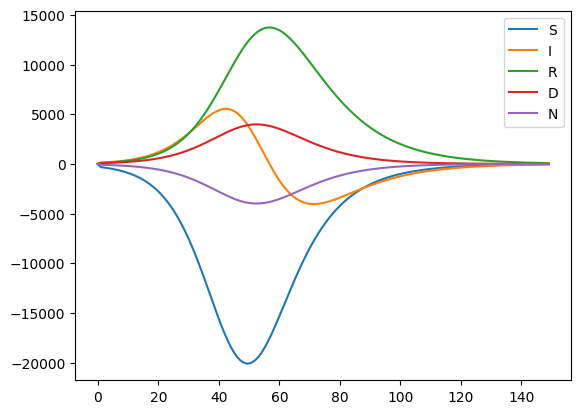

In [23]:
myplot.woplot(weifen,t,'solid')

In [148]:
def simple_with_time(data_with_time, batch_size, train_ratio,isshuffle=False,guiyihua=False,noise=False):
    if noise:
        data_with_time[:,1:]=data_with_time[:,1:]/10000.+0.1*torch.randn(data_with_time[:,1:].shape)
    if guiyihua:
        data_with_time=torch.cat((data_with_time[:,:1],F.normalize(data_with_time[:,1:], dim=0)),dim=1)
    total_size = len(data_with_time)
    train_size = int(total_size * train_ratio)

    train_dataset = TensorDataset(
        data_with_time[:train_size, :6].type(torch.float32),
        data_with_time[:train_size, 6:].type(torch.float32)
    )
    test_dataset = TensorDataset(
        data_with_time[train_size:, :6].type(torch.float32),
        data_with_time[train_size:, 6:].type(torch.float32)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=isshuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [363]:
total=torch.cat((t.unsqueeze(-1),simulation,weifen),dim=1)
train_data,test_data=simple_with_time(total,5,0.9,isshuffle=True,guiyihua=False,noise=True)
for x,y in train_data:
    print(x)
    break

tensor([[ 67.0000,  35.1538,  11.1803,  40.6373,  13.0656,  87.1374],
        [ 22.0000,  96.8807,   1.5326,   1.1729,   0.5757,  99.3340],
        [ 28.0000,  94.0571,   2.4286,   2.2521,   1.1492,  98.8592],
        [121.0000,  21.1943,   0.5031,  61.7878,  16.6503,  83.4052],
        [126.0000,  21.1266,   0.6018,  61.9125,  16.7574,  83.1292]])


In [185]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.beta=nn.Sequential(
            nn.Linear(1,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32,8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(8,1),
        )
        self.mu=nn.Sequential(
            nn.Linear(1,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32,8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(8,1),
        )

    def forward(self, x):
        t=x[:,:1]
        pre_beta=self.beta(t)
        pre_mu=self.mu(t)
        return pre_beta,pre_mu

In [191]:
net = Net()
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.kaiming_uniform_(m.weight)
net.apply(init_weights)
criterion = nn.MSELoss()
optib=torch.optim.Adam(net.beta.parameters(),lr=0.003)
optim=torch.optim.Adam(net.mu.parameters(),lr=0.01)

In [192]:
net.to(device)
for i in range(500):
    for X_train,y_train in train_data:
        X_train,y_train=X_train.to(device),y_train.to(device)
        S,I,D,N=X_train[:,1].reshape(-1,1),X_train[:,2].reshape(-1,1),X_train[:,4].reshape(-1,1),X_train[:,5].reshape(-1,1)
        p=net(X_train)
        beta,mu=p[0],p[1]
        dS=-beta*S*I/N
        dI=beta*S*I/N-(mu+0.1)*I
        dD=mu*I
        # 未必需要
        dN=-dD

        optim.zero_grad()
        loss2=criterion(torch.cat((dI,dD),dim=1),y_train[:,(1,3)])
        # loss2=criterion(dD,y_train[:,3:4])
        loss2.backward(retain_graph=True)
        optim.step()


        optib.zero_grad()
        loss1=criterion(torch.cat((dS,dI),dim=1),y_train[:,(0,1)])
        loss1.backward()
        optib.step()
        #
        # optim.zero_grad()
        # loss2=criterion(torch.cat((dI,dD),dim=1),y_train[:,(1,3)])
        # loss2.backward()
        # optim.step()

        loss=loss1+loss2


    if i%10==0:
        print('Epoch:', i, 'Train loss_beta:', loss1.item(),'Train loss_mu:', loss2.item())

Epoch: 0 Train loss_beta: 3.1243674755096436 Train loss_mu: 1.5960630178451538
Epoch: 10 Train loss_beta: 0.18259237706661224 Train loss_mu: 0.18212886154651642
Epoch: 20 Train loss_beta: 0.16747698187828064 Train loss_mu: 0.10776269435882568
Epoch: 30 Train loss_beta: 0.029920382425189018 Train loss_mu: 0.023799845948815346
Epoch: 40 Train loss_beta: 0.009761596098542213 Train loss_mu: 0.011132876388728619
Epoch: 50 Train loss_beta: 0.028518665581941605 Train loss_mu: 0.03349468857049942
Epoch: 60 Train loss_beta: 0.006936430931091309 Train loss_mu: 0.016695046797394753
Epoch: 70 Train loss_beta: 0.008918680250644684 Train loss_mu: 0.010791872628033161
Epoch: 80 Train loss_beta: 0.016985701397061348 Train loss_mu: 0.011149156838655472
Epoch: 90 Train loss_beta: 0.005363348871469498 Train loss_mu: 0.015678970143198967
Epoch: 100 Train loss_beta: 0.01831180416047573 Train loss_mu: 0.029162708669900894
Epoch: 110 Train loss_beta: 0.012682633474469185 Train loss_mu: 0.006780724972486496
E

In [193]:
net.to('cpu')
pre_beta=net.beta(total[:,0].reshape(-1,1).float()).detach().numpy()
pre_mu=net.mu(total[:,0].reshape(-1,1).float()).detach().numpy()

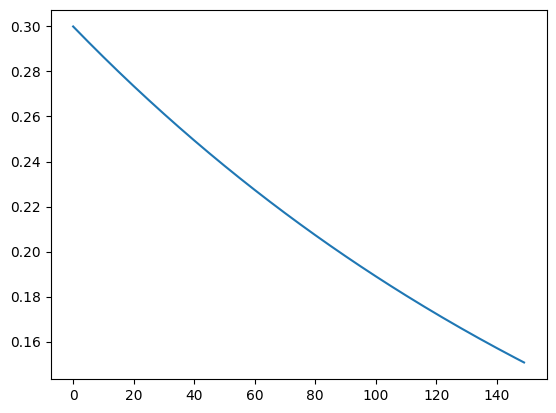

In [10]:
plt.plot(beta(t))

In [11]:
plt.plot(pre_beta)

NameError: name 'pre_beta' is not defined

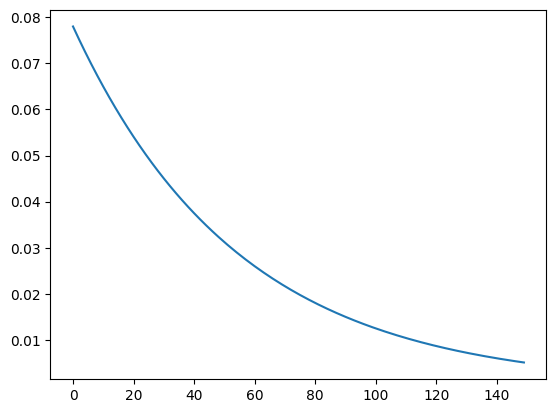

In [12]:
plt.plot(mu(t))

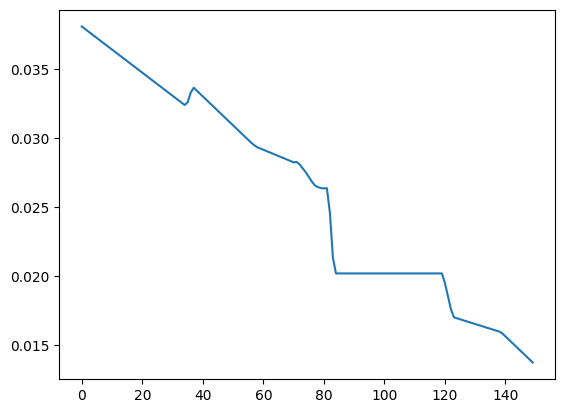

In [195]:
plt.plot(pre_mu)

In [196]:
dS=-torch.tensor(pre_beta).squeeze()*total[:,1]*total[:,2]/total[:,5]
dI=-dS-(0.1+torch.tensor(pre_mu).squeeze())*total[:,2]
dR=0.1*total[:,2]
dD=torch.tensor(pre_mu).squeeze()*total[:,2]
dN=-dD
result = torch.cat((dS.unsqueeze(1), dI.unsqueeze(1), dR.unsqueeze(1), dD.unsqueeze(1), dN.unsqueeze(1)), dim=1)*10000

In [197]:
result.shape

torch.Size([150, 5])

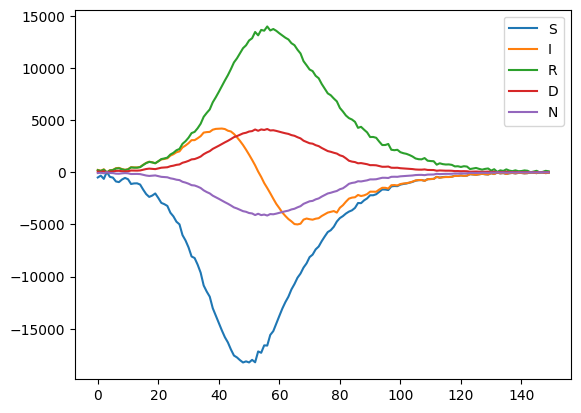

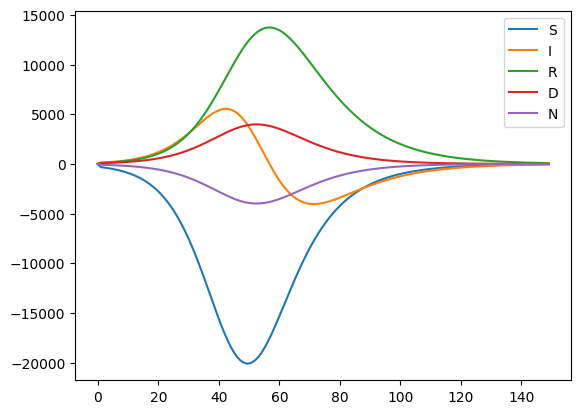

In [199]:
myplot.woplot(result,t,type='solid')
myplot.woplot(weifen,t,type='solid')

In [221]:
def ode(y, t,  gamma):
    S, I, R, D, N = y
    beta=pre_beta[int(t)]
    mu=pre_mu[int(t)]
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    dNdt = -mu * I
    return [dSdt, dIdt, dRdt, dDdt, dNdt]

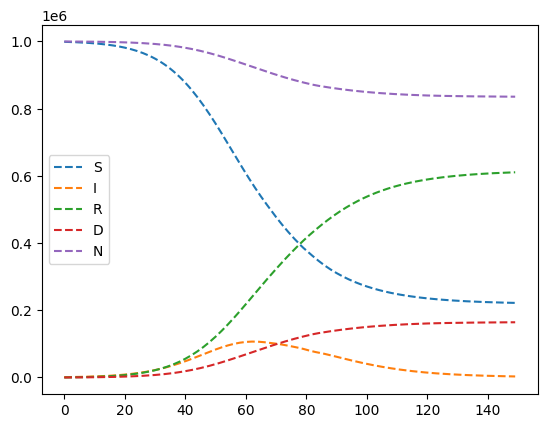

In [226]:
# print(pre_beta)
myplot.woplot(odeint(ode, y0, t, args=(gamma,)),t,'--')

In [509]:
class RNNnet(nn.Module):
    def __init__(self,inputsize,hidden,outputsize):
        super(RNNnet,self).__init__()
        self.hidden_size = hidden
        self.rnn = nn.RNN(inputsize, hidden, batch_first=True)
        self.beta=nn.Sequential(
            nn.Linear(hidden, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(8,2)
        )
        # self.mu=nn.Linear(hidden,1)
        # self.beta = nn.Sequential(
        #     nn.Linear(hidden, 1),
            # nn.BatchNorm1d(4),
            # nn.ReLU(),
            # nn.Linear(4,1)
        # )
        # self.mu = nn.Sequential(
        #     nn.Linear(hidden, 1),
            # nn.BatchNorm1d(4),
            # nn.ReLU(),
            # nn.Linear(4,1)
        # )
        # for layer in [self.beta[0], self.beta[3], self.mu[0], self.mu[3]]:
        for layer in [self.beta[0],self.beta[3]]:
            nn.init.kaiming_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self,x):
        batch_size = x.shape[0]
        t=x[:,:1].reshape(batch_size,1,1)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        out, _ = self.rnn(t, h0)
        out=out.squeeze()
        # beta = self.para(out)
        # print(self.beta(out).shape)
        # return self.beta(out).squeeze(),self.mu(out).squeeze()
        return self.beta(out).squeeze()

In [511]:
rnnnet = RNNnet(1,16,2)
# rnnnet.apply(init_weights)
criterion = nn.MSELoss()
# optib=torch.optim.Adam(rnnnet.beta.parameters(),lr=0.005)
# optim=torch.optim.Adam(rnnnet.mu.parameters(),lr=0.02)
opti=torch.optim.Adam(rnnnet.parameters(),lr=0.03)

In [512]:
rnnnet.to(device)
for i in range(300):
    for X_train,y_train in train_data:
        X_train,y_train=X_train.to(device),y_train.to(device)
        S,I,D,N=X_train[:,1].reshape(-1,1),X_train[:,2].reshape(-1,1),X_train[:,4].reshape(-1,1),X_train[:,5].reshape(-1,1)
        p=rnnnet(X_train)
        beta,mu=p[:,:1],p[:,1:2]
        # beta,mu=p[0].unsqueeze(dim=1),p[1].unsqueeze(dim=1)
        dS=-beta*S*I/N
        dI=beta*S*I/N-(mu+0.1)*I
        dD=mu*I
        # 未必需要
        dN=-dD

        opti.zero_grad()
        loss1=criterion(torch.cat((dS,dI),dim=1),y_train[:,(0,1)])
        loss2=criterion(torch.cat((dI,dD),dim=1),y_train[:,(1,3)])
        loss=loss1+loss2
        loss.backward()
        opti.step()


    if i%10==0:
        print('Epoch:', i, 'Train loss_beta:', loss1.item(),'Train loss_mu:', loss2.item())

Epoch: 0 Train loss_beta: 0.10605078190565109 Train loss_mu: 0.177196204662323
Epoch: 10 Train loss_beta: 0.01968522183597088 Train loss_mu: 0.02242187038064003
Epoch: 20 Train loss_beta: 0.014624464325606823 Train loss_mu: 0.009942244738340378
Epoch: 30 Train loss_beta: 0.021774405613541603 Train loss_mu: 0.013614376075565815
Epoch: 40 Train loss_beta: 0.01169675774872303 Train loss_mu: 0.005789808463305235
Epoch: 50 Train loss_beta: 0.006535737309604883 Train loss_mu: 0.008967776782810688
Epoch: 60 Train loss_beta: 0.010815870948135853 Train loss_mu: 0.009146342054009438
Epoch: 70 Train loss_beta: 0.00948264729231596 Train loss_mu: 0.009693375788629055
Epoch: 80 Train loss_beta: 0.021097708493471146 Train loss_mu: 0.017020583152770996
Epoch: 90 Train loss_beta: 0.014652165584266186 Train loss_mu: 0.01152989361435175
Epoch: 100 Train loss_beta: 0.006260068155825138 Train loss_mu: 0.004919478204101324
Epoch: 110 Train loss_beta: 0.015282812528312206 Train loss_mu: 0.014436537399888039


In [513]:
rnnnet.to('cpu')
out=rnnnet(total[:,:1].float()).detach().numpy().squeeze()
# out=rnnnet(total[:,:1].unsqueeze(dim=1).float())
rnn_beta=out[:,0]
rnn_mu=out[:,1]

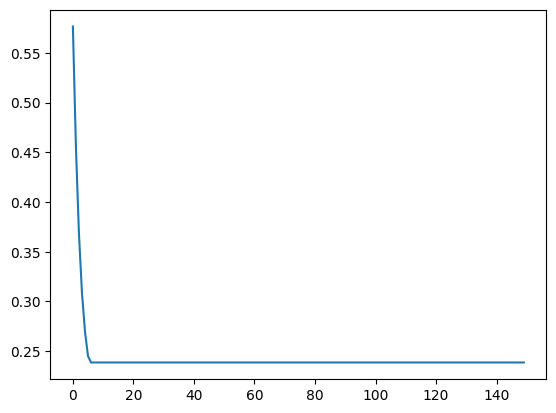

In [514]:
plt.plot(rnn_beta)

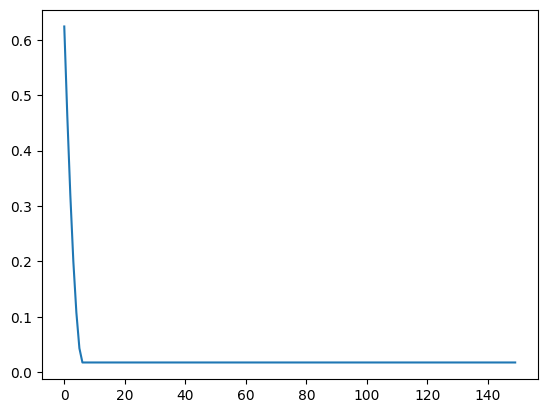

In [515]:
plt.plot(rnn_mu)

In [516]:
dS=-torch.tensor(rnn_beta).squeeze()*total[:,1]*total[:,2]/total[:,5]
dI=-dS-(0.1+torch.tensor(rnn_mu).squeeze())*total[:,2]
dR=0.1*total[:,2]
dD=torch.tensor(rnn_mu).squeeze()*total[:,2]
dN=-dD
result = torch.cat((dS.unsqueeze(1), dI.unsqueeze(1), dR.unsqueeze(1), dD.unsqueeze(1), dN.unsqueeze(1)), dim=1)*10000

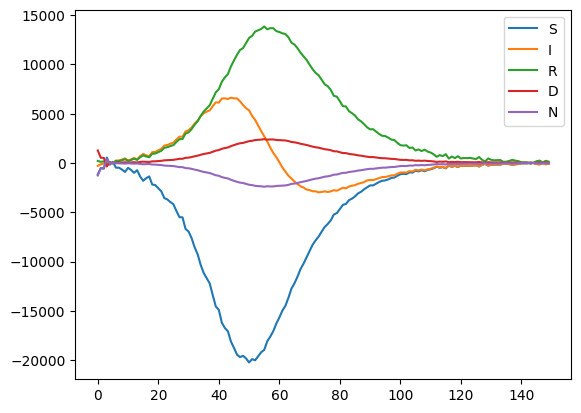

In [517]:
myplot.woplot(result,t,'solid')

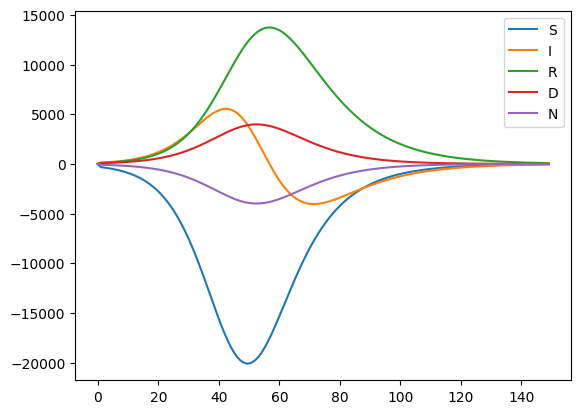

In [487]:
myplot.woplot(weifen,t,'solid')

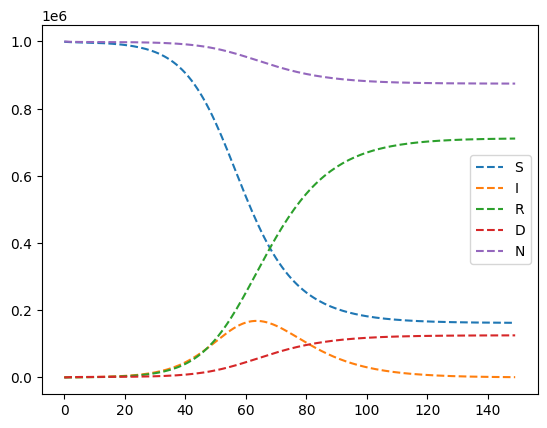

In [520]:
def ode(y, t,  gamma):
    S, I, R, D, N = y
    beta=rnn_beta[int(t)]
    mu=rnn_mu[int(t)]
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    dNdt = -mu * I
    return [dSdt, dIdt, dRdt, dDdt, dNdt]
myplot.woplot(odeint(ode, y0, t, args=(gamma,)),t,'--')

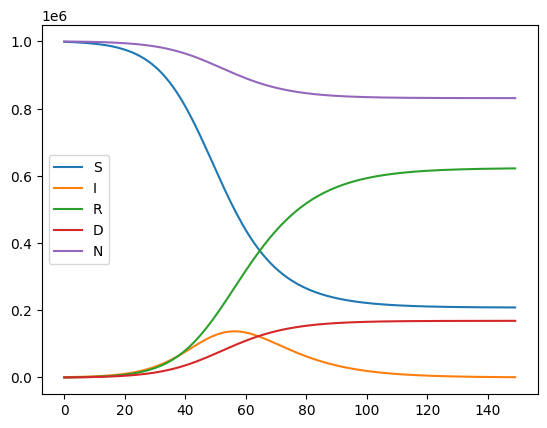

In [13]:
myplot.woplot(simulation,t,'solid')